# About

Training of the BDT to define if track comes from the same side or opposite side.

Labels:
   * 0 (NAN), cannot establish SS or OS
   * -1 (OS) - opposite side tracks (good agreement with indeed OS tracks)
   * 1 (SS) - tracks grandmother, grand-grandmother, grand-grand-grandmother of which is the same as for signal B
   
From test we come up with the statement that SS, NAN should have inverted tracks sing for $K_s$ and $K*$ decays. Thus we train OS vs SS, NAN

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, "../")

# Import

In [3]:
import pandas
import root_numpy
from folding_group import FoldingGroupClassifier
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

# Read $B^\pm \to J\psi K^\pm$ MC samples

In [4]:
data = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root'))

In [5]:
from utils import data_tracks_preprocessing
data = data_tracks_preprocessing(data)

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Initial statistics: {'parts': 33632195, 'Events': 1488891}
after  (ghostProb < 0.4)  selection, statistics: {'parts': 32813556, 'Events': 1488885}
after   ( (PIDNNk > 0.0) | (PIDNNm > 0.0) | (PIDNNe > 0.0) | (PIDNNpi > 0.0) | (PIDNNp > 0.0))   selection, statistics: {'parts': 32808324, 'Events': 1488885}


In [6]:
for group in range(-1, 2, 1):
    print group, 1. * numpy.sum(data.OS_SS.values == group) / len(data)

-1 0.0846154165022
0 0.904321385024
1 0.0110631984737


In [7]:
len(data)

32808324

In [8]:
features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

## distributions for same side vs opposide side tracks

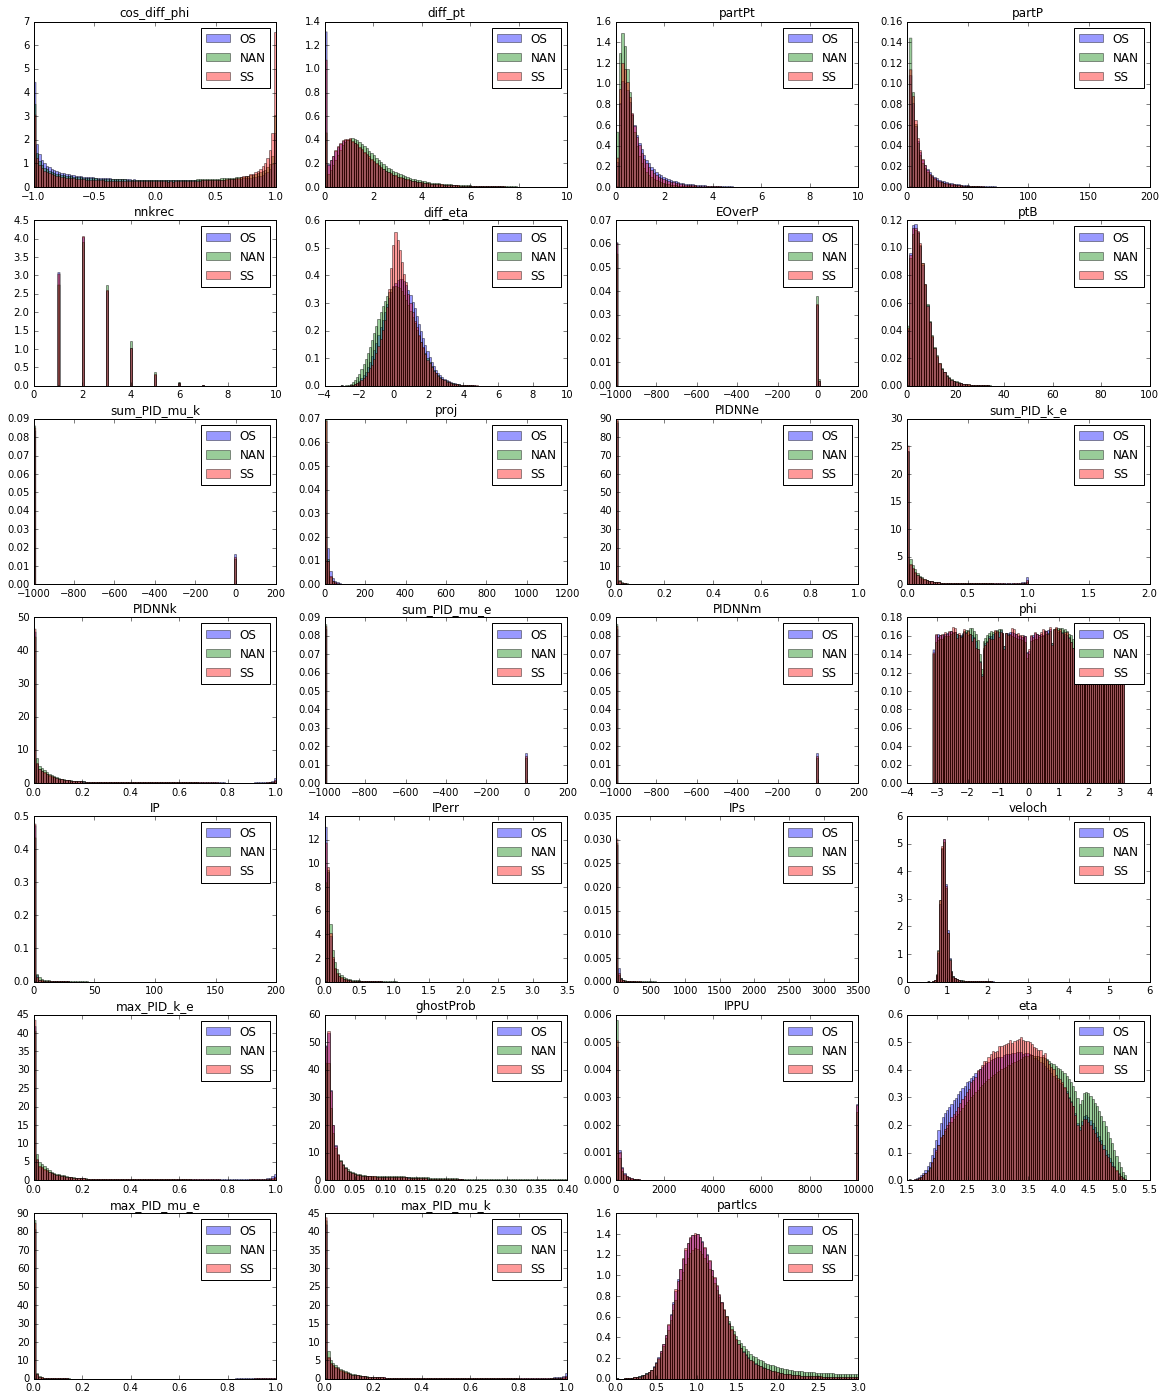

In [9]:
kw = {'bins': 100, 'alpha': 0.4, 'normed': True}
figure(figsize=(20, 35))
for n, f in enumerate(features):
    subplot(10, 4, n + 1)
    r = (numpy.min(data.loc[data.OS_SS == -1, f].values), numpy.max(data.loc[data.OS_SS == -1, f].values))
    hist(data.loc[data.OS_SS == -1, f].values, label='OS', range=r, **kw)
    hist(data.loc[data.OS_SS == 0, f].values, label='NAN', range=r, **kw)
    hist(data.loc[data.OS_SS == 1, f].values, label='SS', range=r, **kw)
    title(f)
    legend()

# Training OS vs SS

In [10]:
data_os_ss = data[data.OS_SS != 0]
weight = numpy.ones(len(data_os_ss))
weight[data_os_ss.OS_SS.values >= 0] *= 1. * sum(data_os_ss.OS_SS < 0) / sum(data_os_ss.OS_SS >= 0)
data_os_ss['weight'] = weight

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
len(data_os_ss)

3139055

In [24]:
from hep_ml.losses import LogLossFunction

In [30]:
loss = LogLossFunction(regularization=100)
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=10000, depth=6, loss=loss,
                                  max_features=15, n_threads=12)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=432, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit(data_os_ss, data_os_ss.OS_SS >= 0)
pass

CPU times: user 43min 38s, sys: 15 s, total: 43min 53s
Wall time: 10min 47s


In [31]:
import cPickle 
with open('../models/dt_ss_os_only.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [32]:
prob = tt_folding.predict_proba(data_os_ss)[:, 1]

KFold prediction using folds column


In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(data_os_ss.OS_SS >= 0, prob, sample_weight=data_os_ss.weight)

0.69828377263840868

KFold prediction using folds column
KFold prediction using folds column


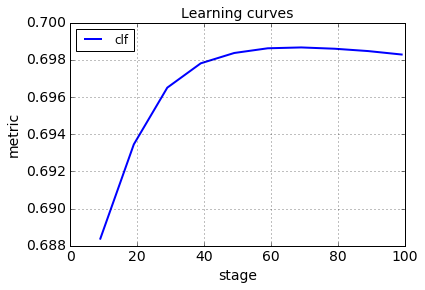

In [34]:
from rep.report.metrics import RocAuc
tt_folding.test_on(data_os_ss, data_os_ss.OS_SS >= 0).learning_curve(RocAuc())

In [43]:
tt_folding.estimators[0].clf.estimators = tt_folding.estimators[0].clf.estimators[:7000]
tt_folding.estimators[1].clf.estimators = tt_folding.estimators[1].clf.estimators[:7000]

In [46]:
prob = tt_folding.predict_proba(data_os_ss)[:, 1]

KFold prediction using folds column


In [53]:
report = tt_folding.test_on(data_os_ss, data_os_ss.OS_SS >= 0)

KFold prediction using folds column


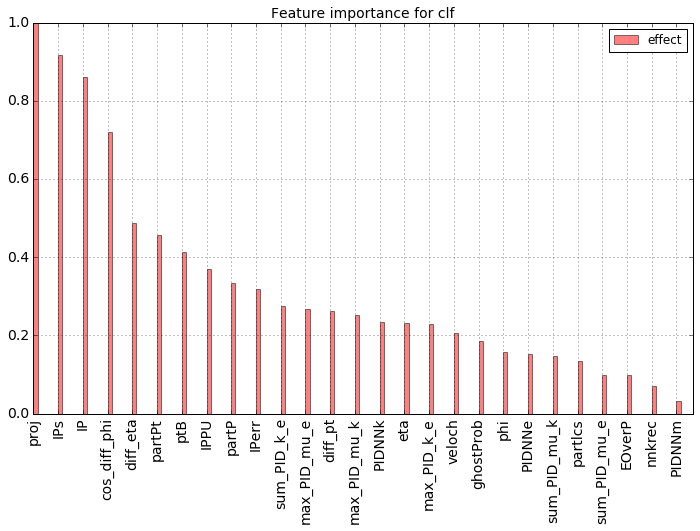

In [55]:
report.feature_importance()

# Calibration to probability to be SS

In [44]:
from utils import plot_calibration

### before calibration

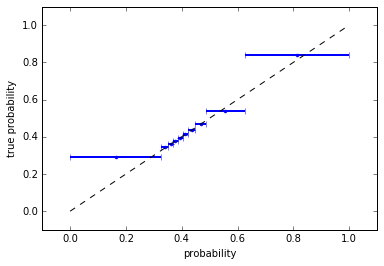

In [47]:
plot_calibration(prob, data_os_ss.OS_SS.values >= 0, weight=data_os_ss.weight.values)

### after calibration

In [48]:
from utils import calibrate_probs

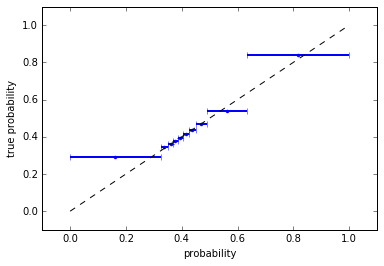

In [49]:
prob_calib, calibrator = calibrate_probs(data_os_ss.OS_SS.values >= 0, data_os_ss.weight.values, prob,
                                         logistic=True)
plot_calibration(prob_calib, data_os_ss.OS_SS.values >= 0, weight=data_os_ss.weight.values)

In [50]:
with open('../models/os_ss_calibrator_only.pkl', 'w') as f:
    cPickle.dump(calibrator, f)

In [ ]:
probs_nan = tt_folding.predict_proba(data[data.OS_SS == 0])[:, 1]
probs_nan_calib = calibrator.predict_proba(probs_nan)

KFold prediction using random classifier (length of data passed not equal to length of train)


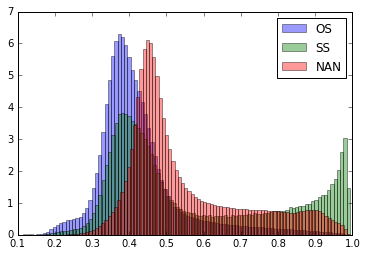

In [ ]:
hist(prob_calib[data_os_ss.OS_SS.values < 0], normed=True, alpha=0.4, label='OS', bins=100);
hist(prob_calib[data_os_ss.OS_SS.values > 0], normed=True, alpha=0.4, label='SS', bins=100);
hist(probs_nan_calib, normed=True, alpha=0.4, label='NAN', bins=100);
legend();

--------------------------------------

# OS vs SS and NAN

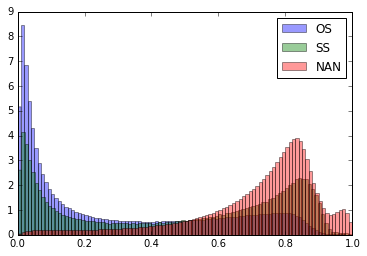

In [20]:
hist(prob_calib[data_os_ss.OS_SS.values < 0], normed=True, alpha=0.4, label='OS', bins=100);
hist(prob_calib[data_os_ss.OS_SS.values > 0], normed=True, alpha=0.4, label='SS', bins=100);
hist(prob_calib[data_os_ss.OS_SS.values == 0], normed=True, alpha=0.4, label='NAN', bins=100);
legend();